## Libraries

In [1]:
#get parameters
import sys
sys.path.append('..')
from src.grass_functions import*
from project_info import *

/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Watershed Parameters

In [2]:
print(f'base data is {select_data}, analysis area is {aoi}')

base data is 10120105, analysis area is 1012010501


In [3]:
dem = f'{dem_base_name}_{select_data}'
if aligned:
    dem +='_a'
if carved:
    dem +='_b'
accum = f'accum_{select_data}'
drain_dir = f'drain_dir_{select_data}'
r_basins = f'r_basins_{select_data}'
v_basins = f'v_basins_{select_data}'
sub_basins = f'subbasins_{select_data}'
v_stream = f'stream_{select_data}'
r_streams = f'r_streams_{select_data}'

### Initiate new grass session

In [4]:
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+sr
Mapset = 'PERMANENT'

In [5]:
initialize_grass_db(Location, Mapset, sr)

Database Location Exists
Database Mapset Exists
None
{'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'nebraska_regression_stantec_26852', 'MAPSET': 'PERMANENT'}


Current GRASS GIS 7 environment:


#### Review existing files

In [6]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
aoi@PERMANENT
aoi_buffer@PERMANENT
nhd1012@PERMANENT
nhd1014@PERMANENT
nhd1015@PERMANENT
nhd1017@PERMANENT
nhd1018@PERMANENT
nhd1019@PERMANENT
nhd1020@PERMANENT
nhd1021@PERMANENT
nhd1022@PERMANENT
nhd1023@PERMANENT
nhd1024@PERMANENT
nhd1025@PERMANENT
nhd1026@PERMANENT
nhd1027@PERMANENT
outlets_10120105@PERMANENT
r_streams_10120105_vect@PERMANENT
r_streams_10120106_vect@PERMANENT
r_streams_10120107_vect@PERMANENT
r_streams_10120108_vect@PERMANENT
r_streams_10120109_vect@PERMANENT
r_streams_10140201_vect@PERMANENT
r_streams_10140202_vect@PERMANENT
r_streams_10140203_vect@PERMANENT
r_streams_10140204_vect@PERMANENT
r_streams_10150002_vect@PERMANENT
r_streams_10150003_vect@PERMANENT
r_streams_10150004_vect@PERMANENT
r_streams_10150005_vect@PERMANENT
r_streams_10150006_vect@PERMANENT
r_streams_10150007_vect@PERMANENT
r_streams_10170101_vect@PERMANENT
r_streams_10170104_vect@PERMANENT
r_streams_10180008_vect@PERMANENT
r_streams_10180009_vect@PERMANENT
r_streams_1018001

#### Remove existing files if needed

In [7]:
#remove old files if needed
remove_grass_data(grass_maps,'None','vector') #all as 

#### Confirm DEM exists

In [8]:
assert dem+"@PERMANENT" in grass_maps['raster'], 'Check that dem exists in GRASS'

#### Import area of interest to GRASS

In [9]:
#prep area of interest
aoi_path = vector_dir/'aoi.geojson'
temp = gpd.read_file(basins)
temp.loc[temp[analysis_scale.lower()] == aoi].to_file(aoi_path, driver="GeoJSON")

/opt/conda/lib/python3.9/site-packages/geopandas/io/file.py:299: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
gs.run_command('v.import', input= aoi_path,  output= 'aoi')
print('added aoi to grass')


         Location PROJ_INFO is:
         name: NAD83 / Nebraska (ftUS)
         datum: nad83
         ellps: grs80
         proj: lcc
         lat_0: 39.8333333333333
         lon_0: -100
         lat_1: 43
         lat_2: 40
         x_0: 500000.00001016
         y_0: 0
         no_defs: defined
         init: EPSG:26852

         Dataset PROJ_INFO is:
         name: NAD83
         datum: nad83
         ellps: grs80
         proj: ll
         no_defs: defined

         ERROR: proj
Importing </home/data/Vectors/nebraska_regression_stantec/aoi.geojson> ...
Check if OGR layer <aoi> contains polygons...
   0 100
Creating attribute table for layer <aoi>...
Default driver / database set to:
driver: sqlite
database: $GISDBASE/$LOCATION_NAME/$MAPSET/sqlite/sqlite.db
Importing 1 features (OGR layer <aoi>)...
   0 100
-----------------------------------------------------
Registering primitives...
-----------------------------------------------------
Cleaning polygons
--------------------------

added aoi to grass


Building topology for vector map <aoi@PERMANENT>...
Registering primitives...
Building areas...
   0 100
Attaching islands...
   0 100
Attaching centroids...
   0 100


#### Buffer area of interest

In [11]:
#add mask and reset region
gs.run_command('v.buffer',input='aoi',output='aoi_buffer',distance = buffer)
#mask outside cells
gs.run_command('r.mask',vector = 'aoi_buffer',overwrite=True)

Buffering areas...
 100
Cleaning buffers...
Building parts of topology...
Building topology for vector map <aoi_buffer@PERMANENT>...
Registering primitives...
Snapping boundaries...
Reading features...
Snap vertices Pass 1: select points
   0 100
Snap vertices Pass 2: assign anchor vertices
   4   9  14  19  24  29  34  39  44  49  54  59  64  69  74  79  84  89  94  99 100
Snap vertices Pass 3: snap to assigned points
   0 100
Breaking polygons...
Breaking polygons (pass 1: select break points)...
 100
Breaking polygons (pass 2: break at selected points)...
 100
Removing duplicates...
 100
Breaking boundaries...
   0 100
Removing duplicates...
 100
Cleaning boundaries at nodes
 100
Building topology for vector map <aoi_buffer@PERMANENT>...
Building areas...
   0 100
Removing dangles...
 100
Removing bridges...
 100
Attaching islands...
Building topology for vector map <aoi_buffer@PERMANENT>...
Attaching islands...
   0 100
Calculating centroids for all areas...
   0 100
Generating lis

0

#### Reset computational region to buffered AOI

In [12]:
#set the region based on the buffer but align with DEM raster
gs.run_command('g.region',raster = dem,align=dem,zoom=dem)

0

#### Plot to confirm

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.


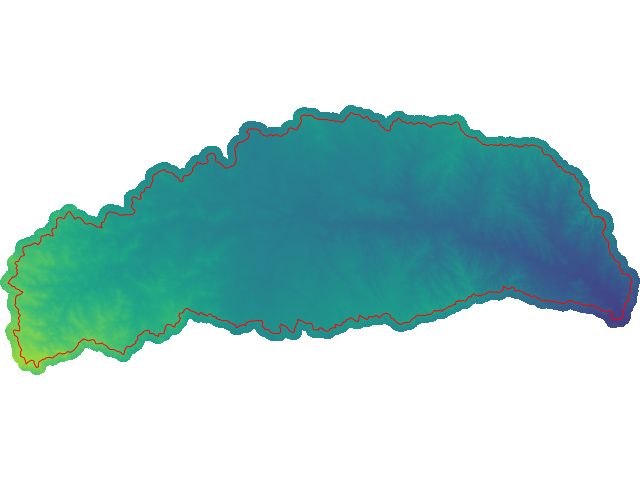

In [13]:
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
gs.run_command('d.vect', map= 'aoi',color='red',fill_color='None')
Image(filename="map.png")

In [14]:
outlets = f'outlets_{select_data}'
if outlet_aois:
    gs.run_command('v.import', input=  outlet_shp,  output= outlets)
else:
    #get outlet point by identifying the highest accumulation value along the perimeter.
    gs.run_command('v.rast.stats', raster=accum, map='aoi',method='max',column='accum')
    max_accum = list(gs.parse_command('v.db.select', columns='accum_maximum',map = 'aoi',flags='c').keys())
    for outlet_accum in max_accum:
        gs.run_command('r.mapcalc',expression = f'r_{outlets} = if({accum} == {outlet_accum},{aoi},null())')
        gs.run_command('r.to.vect', input=f'r_{outlets}', output=outlets, type='point')

Processing input data (1 categories)...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Updating the database ...
         overwritten
Extracting points...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Building topology for vector map <outlets_10120105@PERMANENT>...
Registering primitives...
r.to.vect complete.


#### Plot to confirm

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.
d.vect complete.


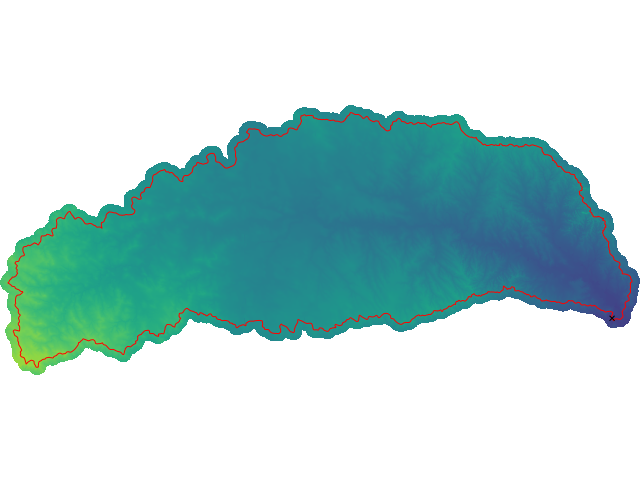

In [15]:
gs.run_command('d.erase')
gs.run_command('d.rast', map= dem)
gs.run_command('d.vect', map= 'aoi',color='red',fill_color='None')
gs.run_command('d.vect', map= outlets,color='black',fill_color='None')
Image(filename="map.png")

#### Export Outlets to Shp

In [16]:
gs.run_command('v.out.ogr',input=outlets,output = outlet_shp,format='ESRI_Shapefile')

Exporting 1 feature...
 100
v.out.ogr complete. 1 feature (Point type) written to <outlets_10120105>
(ESRI_Shapefile format).


0

## Calculate Watershed Attributes and basin Delineation at Points

In [17]:
reg = gs.parse_command('g.region', raster=dem, flags='pg', zoom=dem,align=dem)
cell_size = float(reg.nsres)

In [18]:
threshold = 25899 #cells

In [19]:
gs.run_command('r.watershed', elevation=dem,threshold = threshold,accumulation=accum,drainage=drain_dir,basin=sub_basins,stream=r_streams,flags='sab')

SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Watershed determination.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 5: Closing Maps.
  68 100
Writing out only positive flow accumulation values.
Cells w

0

In [20]:
if outlet_aois:
    gs.run_command('r.stream.snap',input=outlets, 
               output=f'{outlets}_moved',  
               stream_rast=r_streams,
               accumulation=accum, threshold = threshold, radius = 800,
               memory = 4000)
    gs.run_command('r.stream.basins', dir=drain_dir,points = f'{outlets}_moved',basins=r_basins)
else:
    gs.run_command('r.stream.basins', dir=drain_dir,stream_rast = r_streams,basins=r_basins,flags='l')

Reading raster map <r_streams_10270204>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Reading raster map <accum_10270204>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
         overwritten
Building topology for vector map <outlets_10270204_moved@PERMANENT>...
Registering primitives...
Memory swap calculation (may take some time)...
Reading raster map <drain_dir_10270204>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Calculating basins using vector point map...
Delineating basins for 2 outlets...
   0  50 100
Writing raster map <r_basins_10270204>...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [21]:
print("Converting the delineated watershed rasters to vectors")
gs.run_command('r.to.vect', input=r_basins, output= v_basins, type="area", flags='s')

print("Get basin ID from the raster")
basin_IDs = gs.parse_command('r.describe',map = r_basins, flags = '1n' )
basin_list = [int(x) for x in [*basin_IDs]]

Converting the delineated watershed rasters to vectors


         overwritten
Extracting areas...
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
Writing areas...
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
Building topology for vector map <v_basins_10270204@PERMANENT>...
Registering primitives...
Building areas...
   0   4   9  14  19  23  28  33  38  42  47  52  57  61  66  71  76  80  85  90  95 100
Attaching islands...
   0 100
Attaching centroids...
   0  25  50  75 100
r.to.vect complete.


Get basin ID from the raster


   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100


In [22]:
gs.run_command('v.out.ogr',input=v_basins , output=vector_dir/f'basins_{select_data}.shp', format ='ESRI_Shapefile')

Exporting 11 areas (may take some time)...
   9  18  27  36  45  54  63  72  81  90 100
         category are written only when -c flag is given.
v.out.ogr complete. 4 features (Polygon type) written to
<v_basins_10270204> (ESRI_Shapefile format).


0

## Plot the Results

   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
   0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 100
d.vect complete.
d.vect complete.


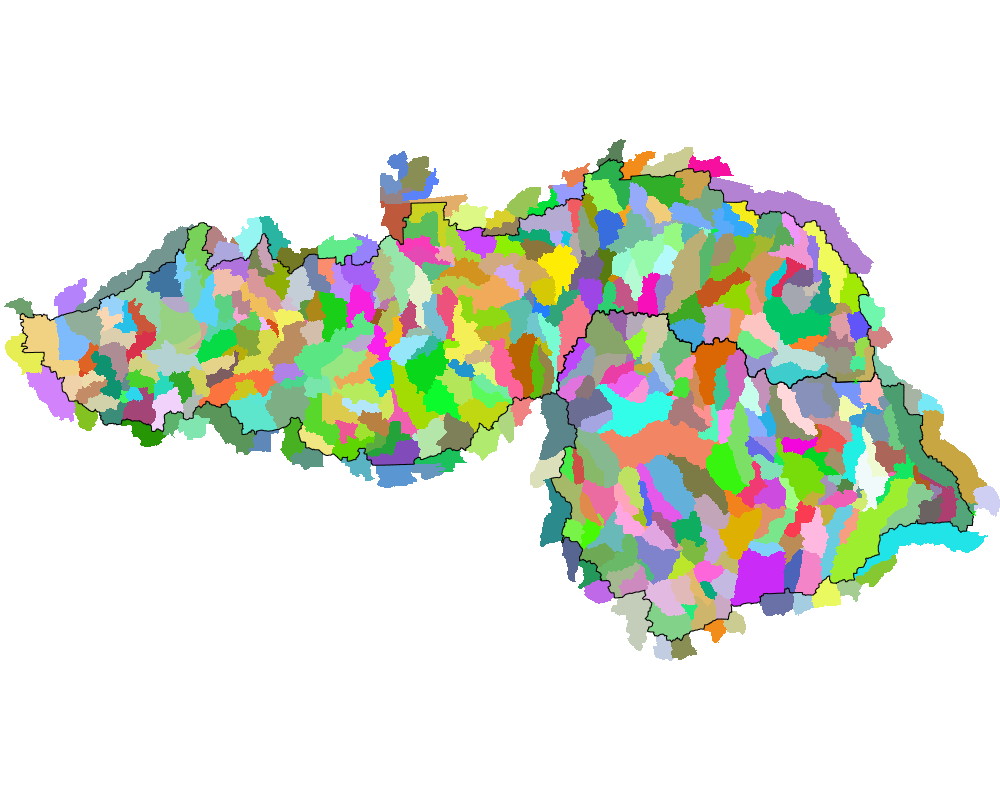

In [23]:
os.environ['GRASS_RENDER_WIDTH'] ='1000' #the width of the image map (default is 640).
os.environ['GRASS_RENDER_HEIGHT']='800' #the height of the image map (default is 480).
gs.run_command('d.erase')
gs.run_command('d.rast', map=sub_basins)
gs.run_command('d.rast', map=r_streams)
if outlet_aois:
    gs.run_command('d.vect', map=v_basins,color='black',fill_color='none')
    gs.run_command('d.vect', map=f'{outlets}_moved',color='green',fill_color='none')
#gs.run_command('d.vect', map=v_stream,color='blue',fill_color='none')
Image(filename="map.png")

In [24]:
# exports

In [25]:
out_rasts = [accum, drain_dir, sub_basins]
for rast in out_rasts:
    gs.run_command('r.out.gdal', input= rast, output= raster_dir/f'{rast}.tif',createopt="BIGTIFF=YES,PROFILE=GeoTIFF,TFW=YES,COMPRESS=LZW",flags='f')

Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Float64>
Input raster map contains cells with NULL-value (no-data). The value -nan
will be used to represent no-data values in the input map. You can specify
a nodata value with the nodata option.
Exporting raster data to GTiff format...
ERROR 6: SetColorTable() only supported for Byte or UInt16 bands in TIFF format.
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
r.out.gdal complete. File
</home/data/Rasters/nebraska_regression_stantec/accum_10270204.tif>
created.
Checking GDAL data type and nodata value...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Using GDAL data type <Int16>
Input raster map contains ce

# END